## North or South ? Which Rates can we expect ? 

In [1]:
import matplotlib.pyplot as plt 
% matplotlib inline

import pandas as pd
import numpy as np

import scipy
from scipy import stats

from random import randint

from astropy.io import fits  ## pip install astropy --no-deps 
from astropy import units as u 

from collections import OrderedDict

from Gilmore_simulation import calculatesignificance,calculaterate
from Gilmore_simulation import calculaterate_GBM
from Gilmore_simulation import plot_simulation, integrate_background
from spectra_LAT import make_DF_from_LGRB
from spectra import make_DF_from_GBM, make_DF_from_BATSE

from uncertainties import unumpy
from uncertainties import ufloat

from ebltable.tau_from_model import OptDepth
tau =  OptDepth.readmodel(model = 'dominguez')

## Realistic expactations on the frequency of different transients

- Where do the transients appear? 
- How often do they appear? 
- How long does CTA luckily look at the right position? 
<br> Therefore understand: 
         - How CTA's pointing works
                 - different telescope sizes
                 - different telescope grouping 
         - How the shedule is made 
         - The sensitivity curves 
         - The isotropic (or non-isotropic) densities
        
         
### 1a Gilmore expactations done with newest data set 

[Paper](https://arxiv.org/pdf/1201.0010.pdf) von Gilmore et.al 2012:
- CGRO BATSE and *Swift* BAT Data in kev range 
- High energy data from *Fermi* LAT 
- Extrapolation with BANDEX and FIXED model depending on BAND function
- EBL attenuation by Gilmore, z distribution uncorrelated to fluence
- effective area and background from CTA (modeled)
- Flux calculation through time and energy integration 
- significance calculation 
- detection rate calculation 

Need catalogs:
- CGRO BATSE catalog BATSE5B (As a .Fit-File [here-browse results](https://heasarc.gsfc.nasa.gov/W3Browse/cgro/bat5bgrbsp.html))
- *SWIFT* GRB Lookuptable(Look up[here](https://swift.gsfc.nasa.gov/archive/grb_table/))
- *Fermi* LAT GRB catalog (As a .Fit-File [here](https://heasarc.gsfc.nasa.gov/W3Browse/fermi/fermilgrb.html))
- *Fermi* GBM GRBs catalog (As a .Fit-File [here](https://heasarc.gsfc.nasa.gov/W3Browse/fermi/fermigbrst.html))

Also need:
- CTAs IRF for different zenith angles and observation times 
- EBL model (new Version by Dominguez reaching z=4) 

Copy steps:
- get Band function indices
- test fixed and bandex model 
- get EBL attenuation 
- fold flux with effective area 
- calculate significances
- check redshift distribution of Fermi LAT bursts
- check flux distributions of LAT bursts

In [2]:
## LAT Catalog online 
LAT_DF = make_DF_from_LGRB('Kataloge/LATGRB.fits')

## catalog Paper with redshift table 
LAT_Redshifts = np.array([4.35,3.57,0.74,0.9,1.82,2.11,0.9,1.06,1.37,2.83])
Redshift_Bursts = np.array(['080916','090323', '090328', '090510','090902',
                           '090926', '091003', '091208', '100414', '110731'])
## Redshifts in a histogram 
plt.hist(LAT_Redshifts, color='indigo')
plt.xlabel(r'Redshift $z$') ; plt.ylabel('# GRBs')
plt.savefig('Plots/Gilmore_Simulation/LAT_Redshifts.pdf')  ; plt.clf()

## Max Energy Loss 
plt.hist(LAT_DF['Emax'], color='#73ac14',bins=10)
plt.xlabel(r'$E_{\mathrm{max}}$ / GeV') ; plt.ylabel('# GRBs')
plt.savefig('Plots/Gilmore_Simulation/LAT_Energies.pdf') ; plt.clf()

## Fluence 
binning = np.logspace(-9,-3,20)
plt.hist(LAT_DF['Fluence'],bins=binning,cumulative=True,histtype='step',density=True, color='indigo')
plt.xscale('log') ; plt.xlabel('Fluence / erg cm$^{-2}$')
plt.ylabel('Fraction GRBs < $F$') ; plt.title('Cummulative fluence distribution')
plt.ylim(-0.05,1.1) ; plt.xlim(1e-9,1e-3)
plt.savefig('Plots/Gilmore_Simulation/LAT_CumFluence.pdf') ; plt.clf()

In [3]:
## GBM catalog
DF = make_DF_from_GBM('Kataloge/GRBST.fits')
## Comparison GBM and LAT 
binning = np.logspace(-9,-3,20)
plt.hist(DF['Fluence'],bins=binning,cumulative=True,histtype='step',density=True, color='#73ac14',
        label='GBM data')
plt.hist(LAT_DF['Fluence'],bins=binning,cumulative=True,histtype='step',density=True, color='indigo',
        label='Joint GBM an LAT data')
plt.xscale('log') ; plt.xlabel('Fluence / erg cm$^{-2}$')
plt.ylabel('Fraction GRBs < $F$') ; plt.title('Cummulative fluence distribution')
plt.ylim(-0.05,1.1) ; plt.xlim(1e-9,1e-3)
plt.legend(loc='upper left') ; plt.savefig('Plots/Gilmore_Simulation/GBM_vs_LAT.pdf')
plt.clf()

GBM_Flu = np.zeros(26) ; Flu_LAT = np.zeros(26)
Fast_GBM = np.zeros(4) ; Fast_LAT = np.zeros(4)
index, index2 = 0,0
#Search for common detections of one GRB 
for i in LAT_DF['Name']:
    LAT = LAT_DF[LAT_DF.Name.str.contains(i)]
    Table = DF[DF.Name.str.contains(i[0:9])]
    if len(Table) == 1:  
        
        if Table['T90/s'].iloc[0] > 2: 
            GBM_Flu[index] = Table['Fluence'].iloc[0]
            Flu_LAT[index] = LAT['Fluence']
            index +=1
        else:
            Fast_GBM[index2] = Table['Fluence'].iloc[0]
            Fast_LAT[index2] = LAT['Fluence']
            index2 +=1 
    if len(Table) == 2:
        if Table['T90/s'].iloc[0] > 2: 
            GBM_Flu[index] = Table['Fluence'].iloc[0]
            Flu_LAT[index] = LAT['Fluence']
            index +=1
        if Table['T90/s'].iloc[1] > 2: 
            GBM_Flu[index] = Table['Fluence'].iloc[1]
            Flu_LAT[index] = LAT['Fluence']
            index +=1
        if Table['T90/s'].iloc[0] <= 2:
            Fast_GBM[index2] = Table['Fluence'].iloc[0]
            Fast_LAT[index2] = LAT['Fluence'] 
            index2 +=1
        if Table['T90/s'].iloc[1] <= 2:
            Fast_GBM[index2] = Table['Fluence'].iloc[1]
            Fast_LAT[index2] = LAT['Fluence'] 
            index2 +=1 
# Plot Fluence Rate            
plt.xlabel('GBM Fluence (10 keV-1 MeV) / erg cm$^{-2}$') 
plt.ylabel('Joint Fluence (10 keV - 10 GeV)/ erg cm$^{-2}$') 
plt.xscale('log') ; plt.yscale('log')
x = np.linspace(Fast_GBM.min(),GBM_Flu.max())
plt.plot(x,x,'--',color='dimgray',label='Fluence ratio 1.0')
plt.plot(x,0.1*x,'-.',color='gray',label='Fluence ratio 0.1')
plt.plot(x,10*x,'-.',color='lightgray',label='Fluence ratio 10')
plt.plot(GBM_Flu,Flu_LAT,'*',color='#73ac14',label='measured long GRBs')
plt.plot(Fast_GBM,Fast_LAT,'*',color='indigo',label='measured short GRBs')
plt.legend() ; plt.title('Fluence ratio = LAT_Fluence/GBM_Fluence')
plt.savefig('Plots/Gilmore_Simulation/LAT_GBM_Fluence.pdf')
plt.clf() 


In [2]:
## SWIFT data 2004-2018 
Name,Flu,z = np.genfromtxt('Kataloge/SWIFT.txt',unpack=True)
Flu = Flu*1e-7 # in erg/cm² between 15 and 150 keV 
## Redshift 
plt.hist(z[z>0],bins=30,color='#73ac14',density=True, alpha=0.6)
plt.xlabel('Redshift $z$') ; plt.ylabel('# GRBs')

gamma = stats.gamma
x = np.linspace(0, z[z>0].max(), 100)
param = gamma.fit(z[z>0]) ; pdf_fitted = gamma.pdf(x, *param)
a = param[0]
plt.plot(x, pdf_fitted, color='indigo', label='Gamma-Fit')

skewnorm = stats.skewnorm
param = skewnorm.fit(z[z>0]) ; pdf_fitted = skewnorm.pdf(x, *param)
plt.plot(x, pdf_fitted, color='darkmagenta', label='Skewnorm')

P = stats.expon.fit(z[z>0])
rX = np.linspace(0,8, 100) ; rP = stats.expon.pdf(rX, *P)
plt.plot(rX, rP, color='lightsteelblue', label='Exponential Fit')
plt.legend()
plt.savefig('Plots/Gilmore_Simulation/SWIFT_Redshifts.pdf')
plt.clf()

## Test density 
r = gamma.rvs(a, size=1000)
#plt.hist(r, histtype='stepfilled', color='#73ac14') ---> Able to randomly drag Redshift 

## Fluence 
binning = np.logspace(-9,-3,20)
plt.hist(Flu[Flu>1e-9],bins=binning,cumulative=True,histtype='step',density=True, color='indigo')
plt.xscale('log')
plt.xlabel('Fluence / erg cm$^{-2}$') ; plt.ylabel('Fraction GRBs < $F$')
plt.title('Cummulative fluence distribution')
plt.ylim(-0.05,1.1) ; plt.xlim(1e-9,1e-3)
plt.savefig('Plots/Gilmore_Simulation/SWIFT_Fluence.pdf') ; plt.clf()

In [3]:
SWIFT_DF = pd.DataFrame({'Name': Name,'Fluence':Flu , 'Redshift': z   
                         })
All_z = SWIFT_DF[SWIFT_DF['Redshift']>0]
Low_z = All_z[All_z['Redshift']<1.2]
Config_z = All_z[All_z['Redshift']>1.2]
Mid_z = Config_z[Config_z['Redshift']<2.43]
High_z = All_z[All_z['Redshift']>2.43]
# Rates
print('Length of Lowest regime (0-1.2) = ',len(Low_z['Redshift']))
print('Length of Middle regime (1.2-2.43)= ',len(Mid_z['Redshift']))
print('Length of Highest regime (>2.43) = ',len(High_z['Redshift']))
# Histogramm 
binning = np.logspace(-9,-3,60)
plt.hist(Low_z['Fluence'],histtype = 'step',cumulative=True, bins=binning,density=True,
        color='#73ac14', label='0.1 < z < 1.2')
plt.hist(Mid_z['Fluence'],histtype = 'step',cumulative=True,bins=binning, density=True,
        color='lightsteelblue', label='1.2 < z < 2.7')
plt.hist(High_z['Fluence'],histtype='step',cumulative=True,bins=binning,density=True,
        color='indigo', label='2.7 < z')

print('The higher the redshfit, the higher the fluence needed for a detection')

plt.xscale('log')
plt.ylim(-0.05,1.1) ; plt.xlim(1e-9,1e-3)
plt.xlabel('Fluence / erg cm$^{-2}$') ; plt.ylabel('Fraction GRBs < $F$')
plt.title('Cummulative fluence distribution')
plt.legend(loc ='upper left')
plt.savefig('Plots/Gilmore_Simulation/SWIFT_z_Fluence.pdf') ; plt.clf()

plt.plot(High_z['Redshift'],High_z['Fluence'],'*', color='indigo')
plt.plot(Mid_z['Redshift'],Mid_z['Fluence'],'*', color='lightsteelblue')
plt.plot(Low_z['Redshift'],Low_z['Fluence'],'*', color='#73ac14')
plt.yscale('log')
plt.xlabel('Redshift $z$') ; plt.ylabel('Fluence / erg cm$^{-2}$')
plt.savefig('Plots/Gilmore_Simulation/SWIFT_z_Fluence_Corr.pdf') ; plt.clf()
print('Pearson correlation Redshift to Fluence: ',
      scipy.stats.pearsonr(All_z['Redshift'],All_z['Fluence'])[0]) #Pearson coefficient and p-Value 

Length of Lowest regime (0-1.2) =  118
Length of Middle regime (1.2-2.43)=  119
Length of Highest regime (>2.43) =  119
The higher the redshfit, the higher the fluence needed for a detection
Pearson correlation Redshift to Fluence:  -0.119884970133


In [19]:
## BATSE with imports from Gilmore_simulation.py 
BATSE_DF = make_DF_from_BATSE('Kataloge/BATSE5B.fits')
BATSE_DF

,Band_A,Band_A_Err,Band_Alpha,Band_Alpha_Err,Band_Beta,Band_Beta_Err,Band_Chi,Band_EP,Band_EP_Err,Band_Fluence,DEC,Duration,Name,RA,Total_Time
0,0.001970,0.000103,-1.36,0.05,-10.69,9999.99,13.92,209.0,14.70,1.320000e-05,0.00,0.000,,0.00,172.03
1,0.001250,0.000644,-0.87,0.61,-2.31,1.52,9.61,324.0,243.00,4.190000e-07,-88.40,0.240,GRB 000203,329.06,4.10
2,0.014900,0.015300,0.02,0.68,-2.15,0.10,13.46,90.0,13.60,2.760000e-06,-88.00,30.144,GRB 970930-,270.24,30.72
3,0.002430,0.000000,-1.61,0.00,-1.56,0.00,672.22,541.0,0.00,1.370000e-06,-87.81,8.384,4B 951019,161.51,12.29
4,0.001100,0.000431,-1.02,0.44,-9.62,9999.99,8.74,392.0,331.00,5.100000e-07,-87.10,3.328,GRB 971124,255.20,8.19
5,0.001670,0.000000,-0.96,0.00,-17.79,0.00,29.98,864.0,0.00,1.150000e-05,-84.96,73.472,4B 920502-,131.99,63.49
6,0.027900,0.000995,-0.87,0.03,-2.72,0.08,15.50,163.0,3.07,2.200000e-05,-84.51,36.992,GRB 970930-,281.45,34.82
7,0.004600,0.001630,-1.31,0.27,-2.11,0.12,10.38,128.0,33.20,2.990000e-06,-84.18,13.184,GRB 961019,321.87,16.38
8,0.002580,0.000142,-1.50,0.06,-2.27,0.21,19.95,283.0,43.50,1.710000e-05,-83.44,328.448,GRB 990411-,329.84,114.69
9,0.004770,0.013500,-1.15,1.74,-2.20,0.15,4.24,67.4,31.70,8.230000e-07,-82.75,7.296,4B 920120,300.31,10.24


### Instrument Response Function 
-----> For folding data with telescope's response <br>
“This research has made use of the CTA instrument response functions provided by the CTA Consortium and Observatory, see http://www.cta-observatory.org/science/cta-performance/ (version prod3b-v1) for more details.”

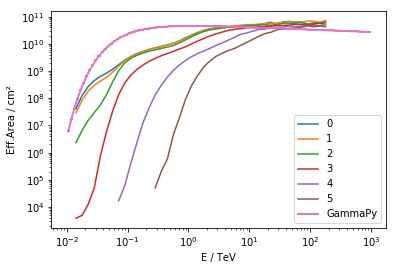

In [8]:
## effective Area
cta_perf_fits = fits.open('/home/jana/Schreibtisch/Projekt Master/caldb/data/cta/prod3b/bcf/South_z20_average_100s/irf_file.fits')
data_A_eff = cta_perf_fits['EFFECTIVE AREA']

a_eff_cta_south = OrderedDict({"E_TeV": (data_A_eff.data['ENERG_LO'][0] + data_A_eff.data['ENERG_HI'][0])/2,
                                "A_eff": data_A_eff.data['EFFAREA'][0]})
plt.plot(a_eff_cta_south['E_TeV'], a_eff_cta_south['A_eff'][0]*1e4, label='0')
plt.plot(a_eff_cta_south['E_TeV'], a_eff_cta_south['A_eff'][1]*1e4, label='1')
plt.plot(a_eff_cta_south['E_TeV'], a_eff_cta_south['A_eff'][2]*1e4, label='2')
plt.plot(a_eff_cta_south['E_TeV'], a_eff_cta_south['A_eff'][3]*1e4, label='3')
plt.plot(a_eff_cta_south['E_TeV'], a_eff_cta_south['A_eff'][4]*1e4, label='4')
plt.plot(a_eff_cta_south['E_TeV'], a_eff_cta_south['A_eff'][5]*1e4, label='5')

energy = np.logspace(-2, 3, 100) * u.TeV
from gammapy.irf import EffectiveAreaTable
for instrument in [ 'CTA']:
    aeff = EffectiveAreaTable.from_parametrization(energy, instrument)
    ax = aeff.plot(label='GammaPy')
plt.legend()
plt.yscale('log') ; plt.xscale('log')
plt.xlabel('E / TeV') ; plt.ylabel('Eff.Area / cm²')
plt.show() ; plt.clf() 
## 0 = OPTIMISTIC = CHOSEN 

plt.plot(a_eff_cta_south['E_TeV'], a_eff_cta_south['A_eff'][0]*1e4, color='#73ac14')
plt.yscale('log') ; plt.xscale('log')
plt.xlabel('E / TeV') ; plt.ylabel('Eff.Area / cm²')
plt.savefig('Plots/Gilmore_Simulation/CTA_Aeff.pdf') ; plt.clf() 

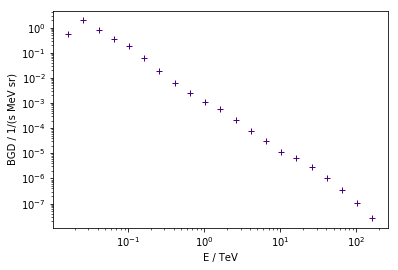

In [9]:
## Instrument Background
data_ang_res = cta_perf_fits['POINT SPREAD FUNCTION']
data_bg_rate = cta_perf_fits['BACKGROUND']

psf_cta_south = OrderedDict({"E_TeV": (data_ang_res.data['ENERG_LO'][0] + data_ang_res.data['ENERG_HI'][0])/2,
                                    "psf_sigma": data_ang_res.data['SIGMA_1'][0]})



Background_cta_south = OrderedDict({"E_TeV": (data_bg_rate.data['ENERG_LO'][0] + data_bg_rate.data['ENERG_HI'][0])/2,
                                   "DetX": (data_bg_rate.data['DETX_LO'][0]+data_bg_rate.data['DETX_HI'][0])/2,
                                 "DetY": (data_bg_rate.data['DETY_LO'][0]+data_bg_rate.data['DETY_HI'][0])/2,
                                    'Background': data_bg_rate.data['BGD']
                              })

All_21 = Background_cta_south['Background'][0]
for i in range(0,21):
    plt.plot(Background_cta_south['E_TeV'][i],All_21[i].max(),'+', color='indigo')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('E / TeV')
plt.ylabel('BGD / 1/(s MeV sr)')
plt.show()

### Folding 

- differential flux + EBL absorption
- effective area
- background distribution 

----> Calculate N$_{on}$ and N$_{off}$

In [7]:
Background_Rates,Energy = integrate_background('/home/jana/Schreibtisch/Projekt Master/caldb/data/cta/prod3b/bcf/South_z20_average_100s/irf_file.fits')# [i].ax = 21 background rates in 1/s
print(Background_Rates[0].max().to(1/u.min)) # per minute to be compared to MAGIC perrfomance 2015

for i in range(0,len(Background_Rates)):
    plt.plot(Energy[i],Background_Rates[i].max(),'+', color='indigo')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('E / TeV') ; plt.ylabel(r'BGD Rate / $\frac{1}{s}$')
plt.savefig('Plots/Gilmore_Simulation/CTA_background_rate.pdf'); plt.clf()

8.002836406230927 1 / min


Start simulation for 910905 with random redshift =  0.1
0.9599769154110965 Sigma reached with a maximum background and EBL absorption
Duration of simulation in seconds:  1800


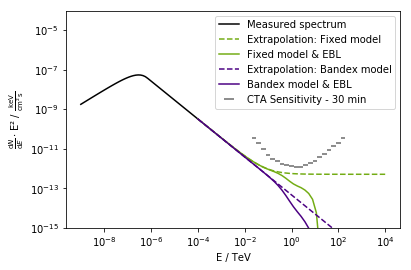

<Quantity 0.9599769154110965>

In [5]:
from Gilmore_simulation import calculaterate_GBM
def simulate_BATSE_detection(Path_to_fits_file,BATSE_DF, GRBname,z,time):
    print('Start simulation for', GRBname, 'with random redshift = ', z)
    BGD_Rate = integrate_background(Path_to_fits_file)[0] # integrate--- has two outputs 
    Gamma_Rate = calculaterate(Path_to_fits_file,GRBname,BATSE_DF,z)
    Sigma = calculatesignificance(Gamma_Rate,BGD_Rate,time,1)
    print(Sigma, 'Sigma reached with a maximum background and EBL absorption')
    print('Duration of simulation in seconds: ',time)
    plot_simulation(GRBname,BATSE_DF,z)
    return Sigma

    
simulate_BATSE_detection('/home/jana/Schreibtisch/Projekt Master/caldb/data/cta/prod3b/bcf/South_z20_average_30m/irf_file.fits',
            BATSE_DF,'910905',0.1,1800)



### Usage of above defined functions

--> Simulate GRB-like transients and calculate significance
      - randomly drag transient's shape by calling a Name out of BATSE_DF['Name']
      - randomly drag transient's redshift by dragging redshift out of gamma density function 

Start simulation for GRB 970424- with random redshift =  0.304892627341


/home/jana/Schreibtisch/Projekt Master/Project_Master/Gilmore_simulation.py:90: RuntimeWarning: invalid value encountered in double_scalars
  return A*(E/(100*1e-9))**(beta)*np.exp(beta-alpha)*(((alpha-beta)*E0)/(100*1e-9))**(alpha-beta)*np.exp(-1. * tau.opt_depth(z,E))
/home/jana/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


nan Sigma reached with a maximum background and EBL absorption
Duration of simulation in seconds:  1800


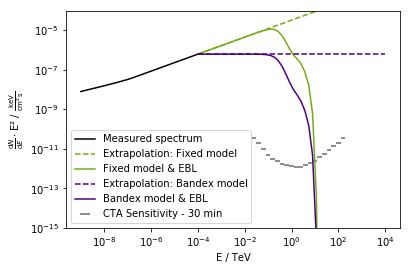

Start simulation for 4B 920628-  with random redshift =  1.71124788665
174.31780994874572 Sigma reached with a maximum background and EBL absorption
Duration of simulation in seconds:  1800


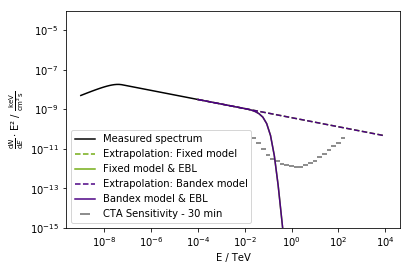

Start simulation for GRB 991107  with random redshift =  2.00198149973
8.056270278188643e-07 Sigma reached with a maximum background and EBL absorption
Duration of simulation in seconds:  1800


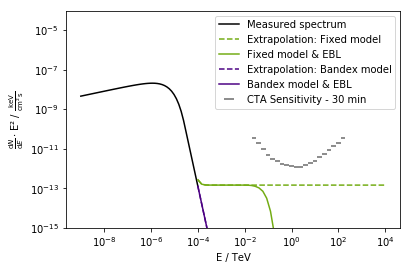

Start simulation for GRB 980310- with random redshift =  4.69058313599
nan Sigma reached with a maximum background and EBL absorption
Duration of simulation in seconds:  1800


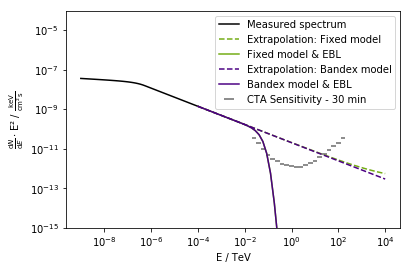

Start simulation for 4B 930301   with random redshift =  0.138469975145
0.0007974877347856862 Sigma reached with a maximum background and EBL absorption
Duration of simulation in seconds:  1800


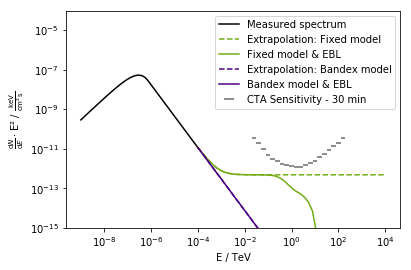

Start simulation for 4B 930910-  with random redshift =  2.11690084268
0.13064695740924695 Sigma reached with a maximum background and EBL absorption
Duration of simulation in seconds:  1800


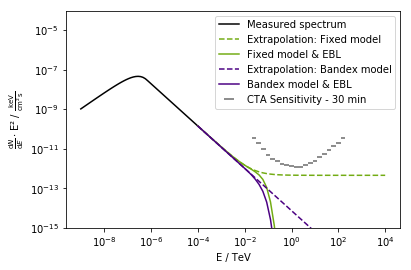

Start simulation for 4B 930315   with random redshift =  1.1765293705
1.358806106850811 Sigma reached with a maximum background and EBL absorption
Duration of simulation in seconds:  1800


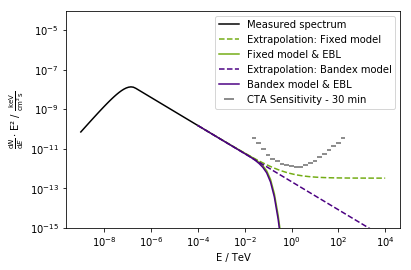

Start simulation for 4B 920708   with random redshift =  1.69709067263
0.0 Sigma reached with a maximum background and EBL absorption
Duration of simulation in seconds:  1800


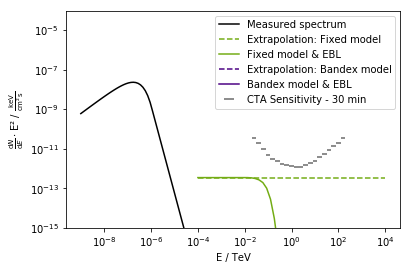

Start simulation for 4B 931106   with random redshift =  1.416254317
1.0442570782548973e-06 Sigma reached with a maximum background and EBL absorption
Duration of simulation in seconds:  1800


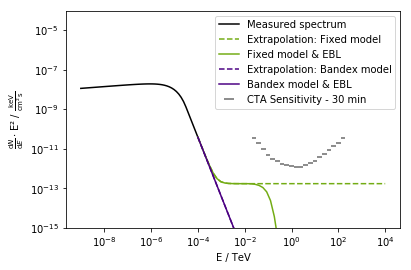

Start simulation for 4B 910927-  with random redshift =  3.084639268
0.0005341359085484496 Sigma reached with a maximum background and EBL absorption
Duration of simulation in seconds:  1800


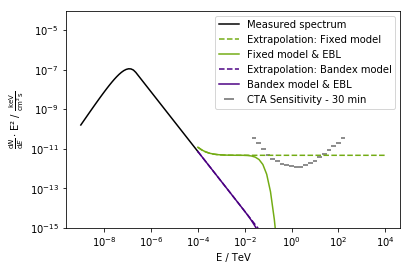

Start simulation for 4B 940902-  with random redshift =  0.703708734529
nan Sigma reached with a maximum background and EBL absorption
Duration of simulation in seconds:  1800


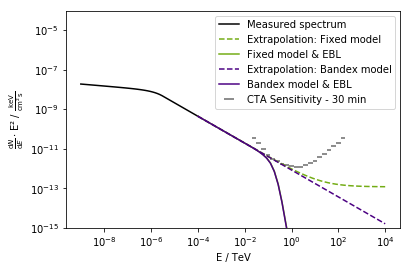

Start simulation for 4B 960414   with random redshift =  1.01585354816
0.0 Sigma reached with a maximum background and EBL absorption
Duration of simulation in seconds:  1800


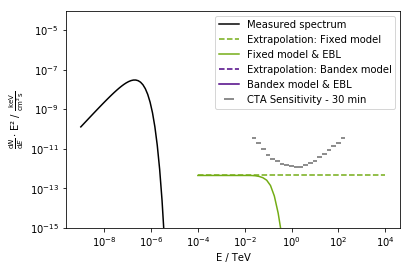

Start simulation for 4B 951011   with random redshift =  1.60281126378
239.5109048100816 Sigma reached with a maximum background and EBL absorption
Duration of simulation in seconds:  1800


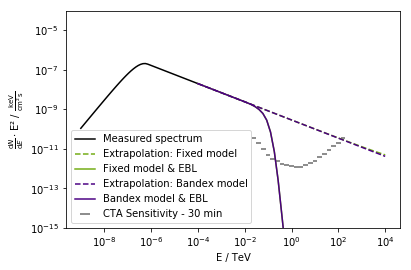

Start simulation for 4B 940623-  with random redshift =  1.94481886264
nan Sigma reached with a maximum background and EBL absorption
Duration of simulation in seconds:  1800


/home/jana/.local/lib/python3.6/site-packages/astropy/units/quantity.py:641: RuntimeWarning: invalid value encountered in sqrt
  *arrays, **kwargs)


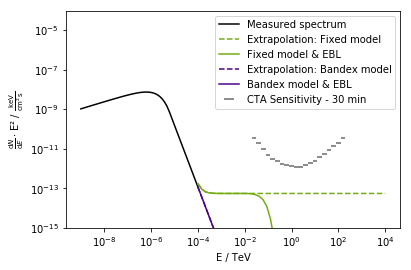

Start simulation for 4B 950806-  with random redshift =  0.0670939797236
nan Sigma reached with a maximum background and EBL absorption
Duration of simulation in seconds:  1800


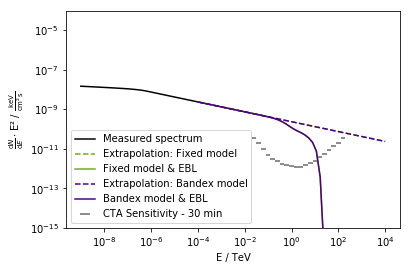

Start simulation for GRB 961009- with random redshift =  3.31879263818
1.5699259069022977e-10 Sigma reached with a maximum background and EBL absorption
Duration of simulation in seconds:  1800


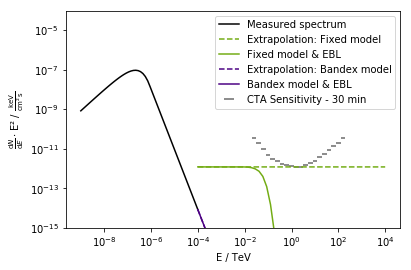

Start simulation for 4B 941009   with random redshift =  0.390850752241
nan Sigma reached with a maximum background and EBL absorption
Duration of simulation in seconds:  1800


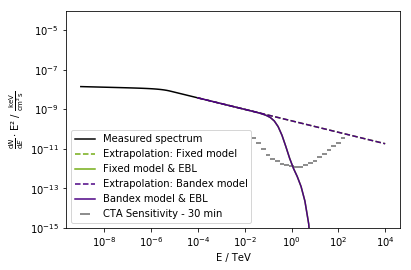

Start simulation for 4B 921001-  with random redshift =  1.62781270755
0.0 Sigma reached with a maximum background and EBL absorption
Duration of simulation in seconds:  1800


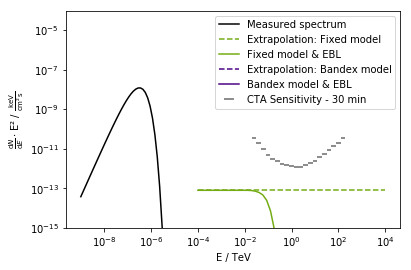

Start simulation for GRB 990403- with random redshift =  3.69390817376
1.2801930288657295 Sigma reached with a maximum background and EBL absorption
Duration of simulation in seconds:  1800


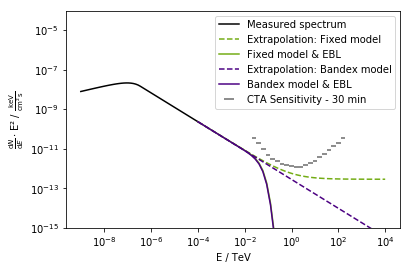

In [21]:
### Name randomly drag from BATSE Dataframe 
### Redshift not known --> Drag from distribution above
N = 20
Sigmas = unumpy.uarray(np.zeros(N), np.zeros(N)) 
for i in range(0,N-1):
    index = randint(0,len(BATSE_DF)-1)
    Name = BATSE_DF['Name'][index]
    z = gamma.rvs(a, size=1)
    z = z[0]

    Sigma = simulate_BATSE_detection('/home/jana/Schreibtisch/Projekt Master/caldb/data/cta/prod3b/bcf/South_z20_average_30m/irf_file.fits',
               BATSE_DF,Name,z,1800)
    if np.isnan(Sigma) == True:
        Sigma = ufloat(0.0,0.0)
    Sigmas[i] = Sigma 

In [8]:
DetectionRate = len(Sigmas[Sigmas>5])/len(Sigmas)
DetectionRate

0.4

## Usage with GBM data

Start simulation for 080916 with (random?) redshift =  0.1
Start IRF part
Ready
4458.136657314744 Sigma reached with a maximum background and EBL absorption
Duration of simulation in seconds:  1800


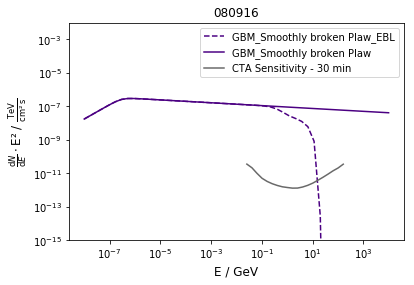

<Quantity 4458.136657314744>

In [22]:
DF = make_DF_from_GBM('Kataloge/GRBST.fits')
from Gilmore_simulation import plot_Flux_Energy
from Sensitivity import plot_Sens

def simulate_GBM_detection(Path_to_fits_file,GBM_DF, GRBname,z,time):
    print('Start simulation for', GRBname, 'with (random?) redshift = ', z)
    BGD_Rate = integrate_background(Path_to_fits_file)[0] # integrate--- has two outputs 
    Gamma_Rate = calculaterate_GBM(Path_to_fits_file,GRBname,GBM_DF,z)
    Sigma = calculatesignificance(Gamma_Rate,BGD_Rate,time,1)
    print(Sigma, 'Sigma reached with a maximum background and EBL absorption')
    print('Duration of simulation in seconds: ',time)
    plot_Flux_Energy(GRBname,GBM_DF,True,z,'indigo')
    plot_Flux_Energy(GRBname,GBM_DF,False,z,'indigo')
    plot_Sens('Tev', 'curve')
    plt.ylim(1e-15,1e-2)
    plt.show()
    return Sigma

simulate_GBM_detection('/home/jana/Schreibtisch/Projekt Master/caldb/data/cta/prod3b/bcf/South_z20_average_30m/irf_file.fits',
                  DF,'080916', 0.1,1800)


Start simulation for GRB140323433 with (random?) redshift =  1.60422021664
Start IRF part
Ready
0.0 Sigma reached with a maximum background and EBL absorption
Duration of simulation in seconds:  1800


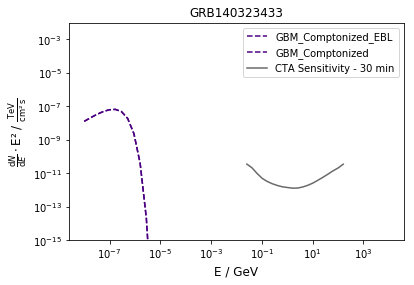

Start simulation for GRB100325246 with (random?) redshift =  1.90536847185
Start IRF part
Ready
1381.706278827652 Sigma reached with a maximum background and EBL absorption
Duration of simulation in seconds:  1800


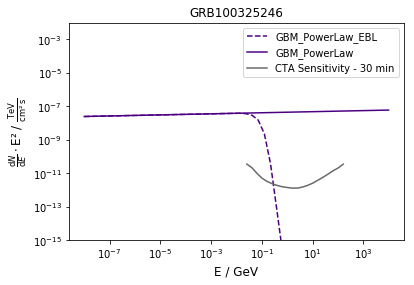

Start simulation for GRB100507577 with (random?) redshift =  1.91401825189
Start IRF part
Ready
0.0 Sigma reached with a maximum background and EBL absorption
Duration of simulation in seconds:  1800


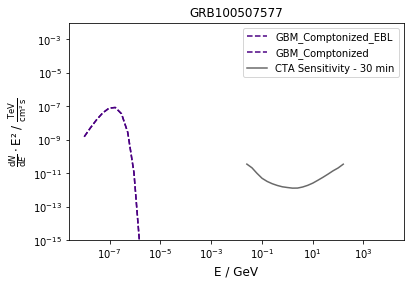

Start simulation for GRB140518709 with (random?) redshift =  4.21149168839
Start IRF part
Ready
180673.6075148894 Sigma reached with a maximum background and EBL absorption
Duration of simulation in seconds:  1800


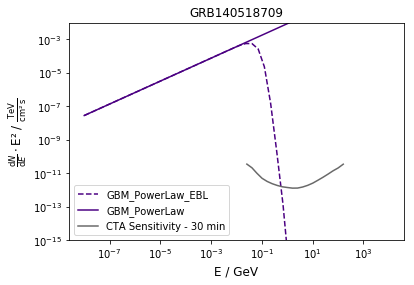

Start simulation for GRB130623488 with (random?) redshift =  2.66471622823
Start IRF part
Ready
0.0 Sigma reached with a maximum background and EBL absorption
Duration of simulation in seconds:  1800


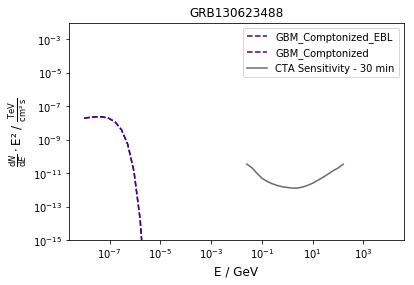

Start simulation for GRB141004150 with (random?) redshift =  1.50150918098
Start IRF part
Ready
1.8350593480841377 Sigma reached with a maximum background and EBL absorption
Duration of simulation in seconds:  1800


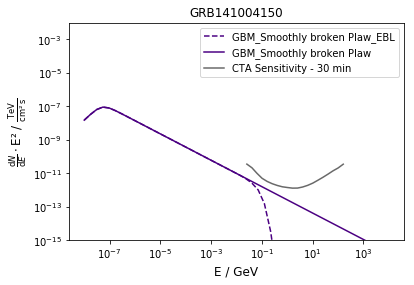

Start simulation for GRB101024486 with (random?) redshift =  1.79951745857
Start IRF part
Ready
8467.20327618141 Sigma reached with a maximum background and EBL absorption
Duration of simulation in seconds:  1800


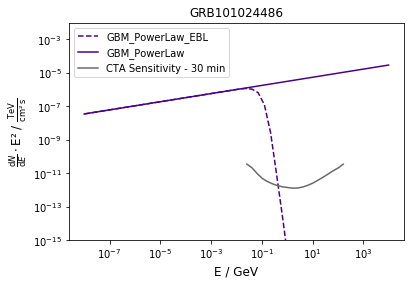

Start simulation for GRB110716018 with (random?) redshift =  0.795904085685
Start IRF part
Ready
0.0 Sigma reached with a maximum background and EBL absorption
Duration of simulation in seconds:  1800


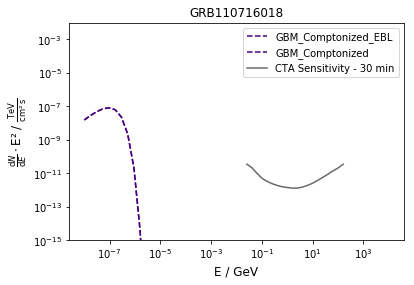

Start simulation for GRB130420422 with (random?) redshift =  3.2975244606
Start IRF part
Ready
0.0 Sigma reached with a maximum background and EBL absorption
Duration of simulation in seconds:  1800


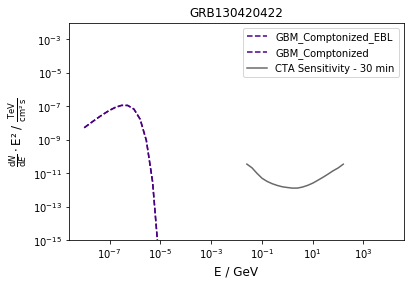

Start simulation for GRB081226044 with (random?) redshift =  4.79446049968
Start IRF part
Ready
78489.34954710021 Sigma reached with a maximum background and EBL absorption
Duration of simulation in seconds:  1800


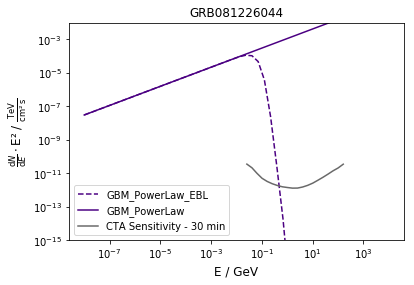

Start simulation for GRB171024977 with (random?) redshift =  2.24636853664
Start IRF part
Ready
0.0 Sigma reached with a maximum background and EBL absorption
Duration of simulation in seconds:  1800


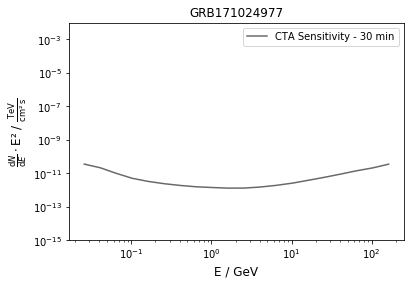

Start simulation for GRB090411838 with (random?) redshift =  1.26279987561
Start IRF part
Ready


NameError: name 'Bandfunc' is not defined

In [11]:
N = len(DF)
Sigmas = unumpy.uarray(np.zeros(N), np.zeros(N)) 
for i in range(0,N-1):
    index = i 
    Name = DF['Name'][index]
    z = gamma.rvs(a, size=1)
    z = z[0]

    Sigma = simulate_GBM_detection('/home/jana/Schreibtisch/Projekt Master/caldb/data/cta/prod3b/bcf/South_z20_average_30m/irf_file.fits',
               DF,Name,z,1800)
    if np.isnan(Sigma) == True:
        Sigma = ufloat(0.0,0.0)
    Sigmas[i] = Sigma 

Start simulation for 090902 with (random?) redshift =  0.5
Start IRF part
Ready
9.803071307320224e-07 Sigma reached with a maximum background and EBL absorption
Duration of simulation in seconds:  1800


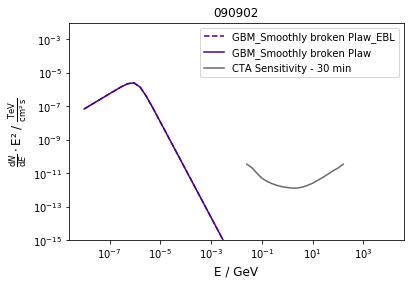

In [14]:
Sigma = simulate_GBM_detection('/home/jana/Schreibtisch/Projekt Master/caldb/data/cta/prod3b/bcf/South_z20_average_30m/irf_file.fits',
               DF,'090902',0.5,1800)

## Usage with Joint LAT and GBM data  


In [15]:
from Gilmore_simulation import calculaterate_and_Plot_Joint
from Gilmore_simulation import integrate_background, calculatesignificance
from Sensitivity import plot_Sens
import matplotlib.pyplot as plt 

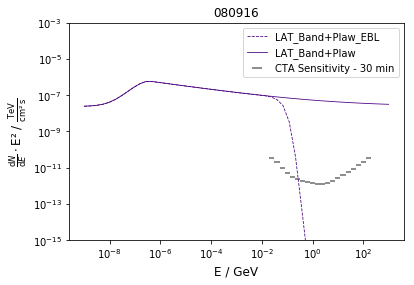

<Quantity 1911.2705886428876>

In [18]:
plot_Sens('Tev', 'binwise')
Gamma_R = calculaterate_and_Plot_Joint('/home/jana/Schreibtisch/Projekt Master/caldb/data/cta/prod3b/bcf/South_z20_average_30m/irf_file.fits',
                            '080916',2.14)
plt.ylim(1e-15,1e-3)
plt.show()
Back_R = integrate_background('/home/jana/Schreibtisch/Projekt Master/caldb/data/cta/prod3b/bcf/South_z20_average_30m/irf_file.fits')[0]
Sigma = calculatesignificance(Gamma_R,Back_R,1800,1)
Sigma

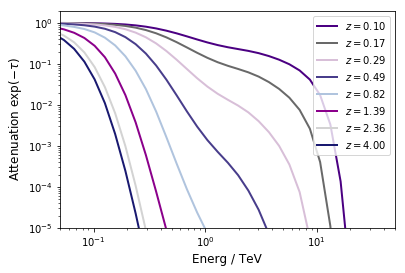

In [42]:
## New EBL method 
colors = np.array(['indigo', 'dimgray','thistle','darkslateblue','lightsteelblue',
                  'darkmagenta','lightgray','midnightblue'])

from ebltable.tau_from_model import OptDepth
tau =  OptDepth.readmodel(model = 'dominguez')
z = np.arange(0.1,4,0.45)
z = np.logspace(np.log10(0.1), np.log10(4), num=8)
ETeV = np.logspace(-2,2.5,50)
atten = np.exp(-1. * tau.opt_depth(z,ETeV))
for i,zz in enumerate(z):
    plt.loglog(ETeV,atten[i],
              ls = '-',color = colors[i],
              label = '$z = {0:.2f}$'.format(zz), lw = 2)

plt.gca().set_ylim((1e-5,2.))
plt.gca().set_xlim((5e-2,5e1))
plt.gca().set_xlabel('Energ / TeV',size = 'large')
plt.gca().set_ylabel(r'Attenuation $\exp(-\tau)$',size = 'large')
plt.legend(loc = 'upper right')
plt.show()